# Use Case: NY Taxi Fare Prediction
An example walk through a data science use case. Base on data from a kaggle challenge https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/overview

This solution is heavily inspire by a block post from [Aiswarya Ramachandran](https://medium.com/analytics-vidhya/machine-learning-to-predict-taxi-fare-part-one-exploratory-analysis-6b7e6b1fbc78) 

In [ ]:
#install python libs
!pip install folium geopy

In [2]:
#import python libs
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from datetime import datetime
import calendar
from math import sin, cos, sqrt, atan2, radians,asin
import folium
from folium import FeatureGroup, LayerControl, Map, Marker
from folium.plugins import HeatMap
from folium.plugins import TimestampedGeoJson
from folium.plugins import MarkerCluster
from geopy.distance import great_circle
import matplotlib.dates as mdates
import matplotlib as mpl
from datetime import timedelta
import datetime as dt
warnings.filterwarnings('ignore')
pd.set_option('display.max_colwidth', -1)
plt.style.use('fivethirtyeight')
import folium
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import Imputer
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import pickle
from geopy.distance import geodesic

In [5]:
##the training data has 55M rows. In this kernel, we shall only read in 6M rows
train=pd.read_csv("../DATA/NY_taxi_train_small.csv") #use only a small part of the full 55Mio data points

### Data Science Workflow

<img src='IMG/workflow.png'>

In [6]:
#let's have a first look at the data
train.head()

,Unnamed: 0,Unnamed: 0.1,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1


In [7]:
# get row data types
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 10 columns):
Unnamed: 0           500000 non-null int64
Unnamed: 0.1         500000 non-null int64
key                  500000 non-null object
fare_amount          500000 non-null float64
pickup_datetime      500000 non-null object
pickup_longitude     500000 non-null float64
pickup_latitude      500000 non-null float64
dropoff_longitude    499995 non-null float64
dropoff_latitude     499995 non-null float64
passenger_count      500000 non-null int64
dtypes: float64(5), int64(3), object(2)
memory usage: 38.1+ MB


### Convert pickup_datetime from Object to Datetime object

In [8]:
train['pickup_datetime']=pd.to_datetime(train['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')
train.head()

,Unnamed: 0,Unnamed: 0.1,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1
1,1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1
2,2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2
3,3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1
4,4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1


### Create datetime features based on pickup_datetime

In [9]:
train['pickup_date']= train['pickup_datetime'].dt.date
train['pickup_day']=train['pickup_datetime'].apply(lambda x:x.day)
train['pickup_hour']=train['pickup_datetime'].apply(lambda x:x.hour)
train['pickup_day_of_week']=train['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
train['pickup_month']=train['pickup_datetime'].apply(lambda x:x.month)
train['pickup_year']=train['pickup_datetime'].apply(lambda x:x.year)

In [10]:
train.head()

,Unnamed: 0,Unnamed: 0.1,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,pickup_date,pickup_day,pickup_hour,pickup_day_of_week,pickup_month,pickup_year
0,0,0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21,-73.844311,40.721319,-73.841610,40.712278,1,2009-06-15,15,17,Monday,6,2009
1,1,1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16,-74.016048,40.711303,-73.979268,40.782004,1,2010-01-05,5,16,Tuesday,1,2010
2,2,2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00,-73.982738,40.761270,-73.991242,40.750562,2,2011-08-18,18,0,Thursday,8,2011
3,3,3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42,-73.987130,40.733143,-73.991567,40.758092,1,2012-04-21,21,4,Saturday,4,2012
4,4,4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00,-73.968095,40.768008,-73.956655,40.783762,1,2010-03-09,9,7,Tuesday,3,2010


### Check for Missing Values 

In [11]:
train[pd.isnull(train)].sum()

Unnamed: 0            0.0
Unnamed: 0.1          0.0
key                   0.0
fare_amount           0.0
pickup_datetime       0.0
pickup_longitude      0.0
pickup_latitude       0.0
dropoff_longitude     0.0
dropoff_latitude      0.0
passenger_count       0.0
pickup_date           0.0
pickup_day            0.0
pickup_hour           0.0
pickup_day_of_week    0.0
pickup_month          0.0
pickup_year           0.0
dtype: float64

There are no missing values in the data.

### Exploratory Data Analysis

** Distribution of Trip Fare**

Text(0.5, 1.0, 'Distribution of Trip Fare')

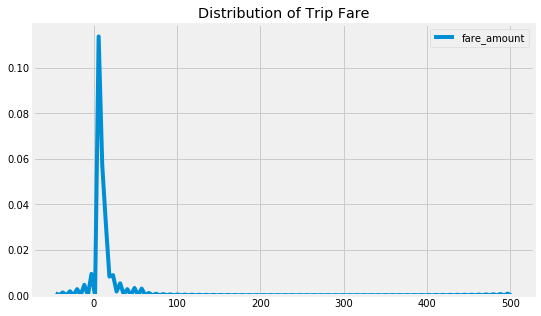

In [12]:
plt.figure(figsize=(8,5))
sns.kdeplot(train['fare_amount']).set_title("Distribution of Trip Fare")

There are some negative fare amount in the data and also it is skewed. Let us have a look at these data points

In [13]:
train.loc[train['fare_amount']<0].shape

(21, 16)

There are 262 records with negative fare. We will remove these records from the data

In [14]:
train=train.loc[train['fare_amount']>=0]
train.shape

(499979, 16)

Since we saw above that fare amount is highly skewed,let us take log transformation of the fare amount and plot the distribution

Text(0.5, 1.0, 'Distribution of fare amount (log scale)')

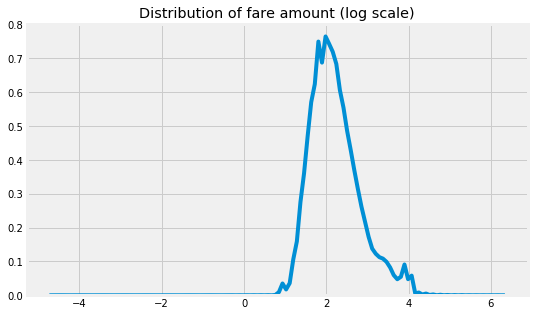

In [15]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(train['fare_amount'].values)).set_title("Distribution of fare amount (log scale)")

1. Most fares are between 2.7   and   54 dollars .Median fare is around $7

### Let us look at Geographical Features and their relationship with Fare Amount

**Distribution of Pickup and Dropoff Lat Lng**

In [16]:
print("Range of Pickup Latitude is ", (min(train['pickup_latitude']),max(train['pickup_latitude'])))

Range of Pickup Latitude is  (-3116.285383, 1703.092772)


In [17]:
print("Range of Dropoff Latitude is ", (min(train['dropoff_latitude']),max(train['dropoff_longitude'])))

Range of Dropoff Latitude is  (-2559.748913, 40.851027)


The data is for Taxi Rides in Newyork, whose center lat, lng is at ((40,-74).The range of dropoff and pickup latitudes indicates lot of outlier locations in the train data. 

In [18]:
#Before we  ahead and identify outlier location, let us read the test data and see what the boundaries are.
test =  pd.read_csv('../DATA/NY_taxi_test.csv')
print("Longitude Boundary in test data")
min(test.pickup_longitude.min(), test.dropoff_longitude.min()),max(test.pickup_longitude.max(), test.dropoff_longitude.max())

Longitude Boundary in test data


(-74.263242, -72.986532)

In [19]:
print("Latitude Boundary in test data")
min(test.pickup_latitude.min(), test.pickup_latitude.min()),max(test.pickup_latitude.max(), test.pickup_latitude.max())

Latitude Boundary in test data


(40.573143, 41.709555)

 Let us set the boundary for the train data also based on test data lat lng boundaries.We will mark the outlier locations as 1 and remove them for further analysi

In [20]:
boundary={'min_lng':-74.263242,
              'min_lat':40.573143,
              'max_lng':-72.986532, 
              'max_lat':41.709555}




There are a lot of cases where lat lng is zero. How many such cases are there in the data?

In [21]:
train[(train.pickup_latitude==0) | (train.pickup_longitude)==0 | (train.dropoff_latitude==0)|(train.dropoff_longitude==0)].shape

(9472, 16)

 114K records  have either pickup/dropoff lat/lng as 0.0 . There is a high chance this is present in test data as well. So, let us create a field called is_outlier_loc and mark as 1 in case it is an outlier. Any point beyond NYC border is an outlier.  We will also drop all rows where the pickup or dropoff location is an outlier


In [22]:
train.loc[~((train.pickup_longitude >= boundary['min_lng'] ) & (train.pickup_longitude <= boundary['max_lng']) &
            (train.pickup_latitude >= boundary['min_lat']) & (train.pickup_latitude <= boundary['max_lat']) &
            (train.dropoff_longitude >= boundary['min_lng']) & (train.dropoff_longitude <= boundary['max_lng']) &
            (train.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=1
train.loc[((train.pickup_longitude >= boundary['min_lng'] ) & (train.pickup_longitude <= boundary['max_lng']) &
            (train.pickup_latitude >= boundary['min_lat']) & (train.pickup_latitude <= boundary['max_lat']) &
            (train.dropoff_longitude >= boundary['min_lng']) & (train.dropoff_longitude <= boundary['max_lng']) &
            (train.dropoff_latitude >=boundary['min_lat']) & (train.dropoff_latitude <= boundary['max_lat'])),'is_outlier_loc']=0

print("Outlier vs Non Outlier Counts")
print(train['is_outlier_loc'].value_counts())

# Let us drop rows, where location is outlier
train=train.loc[train['is_outlier_loc']==0]
train.drop(['is_outlier_loc'],axis=1,inplace=True)

Outlier vs Non Outlier Counts
0.0    489356
1.0    10623 
Name: is_outlier_loc, dtype: int64


128K records are outliers

### Plot Heatmap of Pickups and Dropoffs within NYC

(-74.03, -73.75)

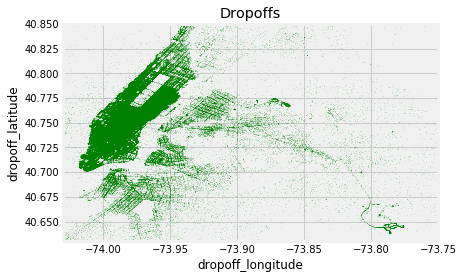

In [23]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

train.plot(kind='scatter', x='dropoff_longitude', y='dropoff_latitude',
                color='green', 
                s=.02, alpha=.6)
plt.title("Dropoffs")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

(-74.03, -73.75)

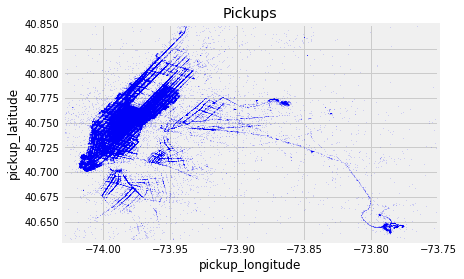

In [24]:

train.plot(kind='scatter', x='pickup_longitude', y='pickup_latitude',
                color='blue', 
                s=.02, alpha=.6)
plt.title("Pickups")

plt.ylim(city_lat_border)
plt.xlim(city_long_border)

Apart from Manhattan, we can see heavy pickups and dropoffs near JFK and La Guardia Airport. 

**Heatmap based on fare amount across NYC**

In [25]:
# Let us round pickup and dropoff lat lng to 3 decimal places
train['pickup_latitude_round3']=train['pickup_latitude'].apply(lambda x:round(x,3))
train['pickup_longitude_round3']=train['pickup_longitude'].apply(lambda x:round(x,3))
train['dropoff_latitude_round3']=train['dropoff_latitude'].apply(lambda x:round(x,3))
train['dropoff_longitude_round3']=train['dropoff_longitude'].apply(lambda x:round(x,3))


In [26]:
pickup_fare_amount=train.groupby(['pickup_latitude_round3','pickup_longitude_round3'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare'})
pickup_fare_amount.head()

,pickup_latitude_round3,pickup_longitude_round3,avg_fare
0,40.576,-74.169,98.0
1,40.576,-73.938,14.5
2,40.577,-73.964,5.7
3,40.578,-73.920,5.3
4,40.580,-73.960,6.5


## In the scatter plot, we saw the high density of pickups and dropoffs from and to JFK and La Guardia Airport
Let us look at over time how fares are from La Guardia and JFK

In [27]:
JFK={'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
JFK_center=[40.6437,-73.7900]
# Get all pickups to JFK
JFK_data=train.loc[(train.pickup_latitude>=JFK['min_lat']) & (train.pickup_latitude<=JFK['max_lat'])]
JFK_data=JFK_data.loc[(train.pickup_longitude>=JFK['min_lng']) & (train.pickup_longitude<=JFK['max_lng'])]

print("Number of Trips with Pickups from JFK",JFK_data.shape[0])

JFK_dropoff=train.loc[(train.dropoff_latitude>=JFK['min_lat']) & (train.dropoff_latitude<=JFK['max_lat'])]
JFK_dropoff=JFK_dropoff.loc[(train.dropoff_longitude>=JFK['min_lng']) & (train.dropoff_longitude<=JFK['max_lng'])]

print("Number of Trips with Dropoffs to JFK",JFK_dropoff.shape[0])

Number of Trips with Pickups from JFK 7495
Number of Trips with Dropoffs to JFK 3886


In [28]:
# Create a folium map with JFK as the center 
m=folium.Map(location =JFK_center,zoom_start = 10,)
folium.Marker(location=JFK_center, popup='JFK Airport',icon=folium.Icon(color='black')).add_to(m)

#mc = MarkerCluster().add_to(m)
#Add markers in blue for each pickup location and line between JFK and Pickup location over time. The thickness of line indicates the fare_amount

for index,row in JFK_data.iterrows():
    folium.Marker([row['dropoff_latitude'],row['dropoff_longitude']]).add_to(m)

#call map
m    

**What is the Average Fare amount of trips from JFK**

Text(0.5, 1.0, 'Fare Amount Distribution')

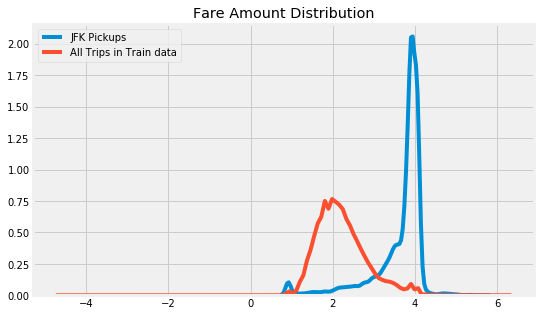

In [29]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(JFK_data['fare_amount'].values),label='JFK Pickups')
#sns.kdeplot(np.log(JFK_dropoff['fare_amount'].values),label='JFK Dropoff')
sns.kdeplot(np.log(train['fare_amount'].values),label='All Trips in Train data')
plt.title("Fare Amount Distribution")

As we can see, the fare amount is much higher when pickup is from JFK.

Text(0.5, 1.0, 'Dropoffs vs Fare Amount')

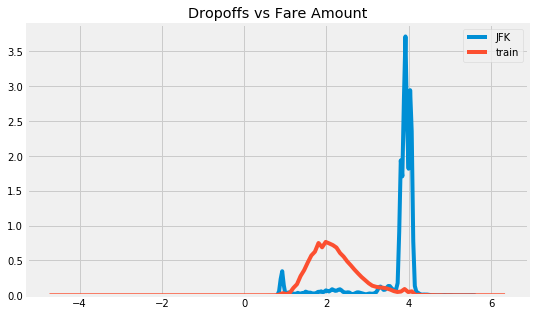

In [30]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(JFK_dropoff['fare_amount'].values),label='JFK')
sns.kdeplot(np.log(train['fare_amount'].values),label='train')
plt.title("Dropoffs vs Fare Amount")

In [31]:
del JFK_data
del JFK
del JFK_dropoff


 Distribution of fare amount for  both pickup and dropoff to JFK is similar

In [32]:
## Based on the above, let us create a function to see whether pickup or dropoff is an Airport. 

'''
def isAirport(latitude,longitude,airport_name='JFK'):
    if airport_name=='JFK':
        boundary={'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659}
    elif airport_name=='EWR':
        boundary={
            'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        }
    elif airport_name=='la guardia':
        boundary={'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
                 }
    if latitude>=boundary['min_lat'] and latitude<=boundary['max_lat']:
        if longitude>=boundary['min_lng'] and longitude<=boundary['max_lng']:
            return 1
    else:
        return 0
        


'''

nyc_airports={'JFK':{'min_lng':-73.8352,
     'min_lat':40.6195,
     'max_lng':-73.7401, 
     'max_lat':40.6659},
              
    'EWR':{'min_lng':-74.1925,
            'min_lat':40.6700, 
            'max_lng':-74.1531, 
            'max_lat':40.7081

        },
    'LaGuardia':{'min_lng':-73.8895, 
                  'min_lat':40.7664, 
                  'max_lng':-73.8550, 
                  'max_lat':40.7931
        
    }
    
}
def isAirport(latitude,longitude,airport_name='JFK'):
    
    if latitude>=nyc_airports[airport_name]['min_lat'] and latitude<=nyc_airports[airport_name]['max_lat'] and longitude>=nyc_airports[airport_name]['min_lng'] and longitude<=nyc_airports[airport_name]['max_lng']:
        return 1
    else:
        return 0
        


In [33]:
train['is_pickup_JFK']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
train['is_dropoff_JFK']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)

In [34]:
train['is_pickup_EWR']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
train['is_dropoff_EWR']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)

In [35]:
train['is_pickup_la_guardia']=train.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
train['is_dropoff_la_guardia']=train.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)

**Trip Distance**

In [36]:
#calculate trip distance in miles
def distance(lat1, lat2, lon1,lon2):
    p = 0.017453292519943295 # Pi/180
    a = 0.5 - np.cos((lat2 - lat1) * p)/2 + np.cos(lat1 * p) * np.cos(lat2 * p) * (1 - np.cos((lon2 - lon1) * p)) / 2
    return 0.6213712 * 12742 * np.arcsin(np.sqrt(a))

In [37]:
train['trip_distance']=train.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)

Text(0.5, 1.0, 'Distribution of Trip Distance (log scale)')

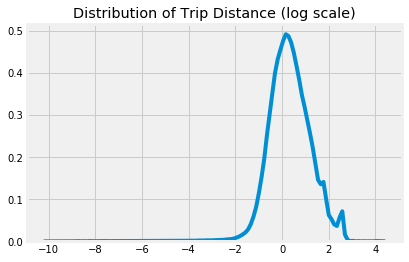

In [38]:
sns.kdeplot(np.log(train['trip_distance'].values)).set_title("Distribution of Trip Distance (log scale)")

Text(0, 0.5, 'Fare Amount')

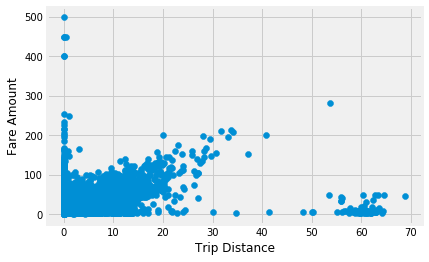

In [39]:
plt.scatter(x=train['trip_distance'],y=train['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")


The fare seems to be fixed for trip distances > 50 miles. Normally airports pickup or dropoff have fixed prices.
We can remove the airport pickup and dropoff and plot the distribution of Fare Amount vs Trip distribution 

In [40]:
non_airport=train.loc[(train['is_dropoff_JFK']==0) & (train['is_dropoff_EWR']==0) & (train['is_dropoff_la_guardia']==0)]
non_airport=non_airport.loc[(non_airport['is_pickup_JFK']==0) & (non_airport['is_pickup_EWR']==0) & (non_airport['is_pickup_la_guardia']==0)]
non_airport.shape

(462072, 27)

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (excluding airport rides)')

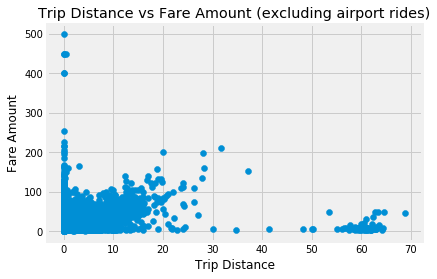

In [41]:
plt.scatter(x=non_airport['trip_distance'],y=non_airport['fare_amount'])
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (excluding airport rides)")

In the plot above, we can see two clusters with linear realtionship between taxi fare and distance. But for trip distances >50miles, though a linear relationship exists,the fare amount is very low. Let us check where these trips originate and end

In [42]:
non_airport_long_trips=non_airport[non_airport['trip_distance']>=50]

In [43]:
drop_map = folium.Map(location = [40.730610,-73.935242],zoom_start = 12,)
#print(pickup.shape)
### For each pickup point add a circlemarker

for index, row in non_airport_long_trips.iterrows():
    
    folium.CircleMarker([row['dropoff_latitude_round3'], row['dropoff_longitude_round3']],
                        radius=3,
                        
                        color="#008000", 
                        fill_opacity=0.9
                       ).add_to(drop_map)
for index, row in non_airport_long_trips.iterrows():
    
    folium.CircleMarker([row['pickup_latitude_round3'], row['pickup_longitude_round3']],
                        radius=3,
                        
                        color="blue", 
                        fill_opacity=0.9
                       ).add_to(drop_map)

'''
hm_wide = HeatMap( list(zip(drop.dropoff_latitude_round3.values, drop.dropoff_longitude_round3.values, drop.Num_Trips.values)),
                     min_opacity=0.2,
                     radius=5, blur=15,
                     max_zoom=1 
                 )
drop_map.add_child(hm_wide)

'''

drop_map

Most of the long trips dropoffs and pickups are in lower Manhattan. There are a lot of dropoffs in Brooklyn

New York city is divided into 7 Boroughs. Let us calculate which borough pickup and dropoff points are. And whether that effects the fare

In [44]:
nyc_boroughs={
    'manhattan':{
        'min_lng':-74.0479,
        'min_lat':40.6829,
        'max_lng':-73.9067,
        'max_lat':40.8820
    },
    
    'queens':{
        'min_lng':-73.9630,
        'min_lat':40.5431,
        'max_lng':-73.7004,
        'max_lat':40.8007

    },

    'brooklyn':{
        'min_lng':-74.0421,
        'min_lat':40.5707,
        'max_lng':-73.8334,
        'max_lat':40.7395

    },

    'bronx':{
        'min_lng':-73.9339,
        'min_lat':40.7855,
        'max_lng':-73.7654,
        'max_lat':40.9176

    },

    'staten_island':{
        'min_lng':-74.2558,
        'min_lat':40.4960,
        'max_lng':-74.0522,
        'max_lat':40.6490

    }
    
    
    
}

In [45]:
def getBorough(lat,lng):
    
    locs=nyc_boroughs.keys()
    for loc in locs:
        if lat>=nyc_boroughs[loc]['min_lat'] and lat<=nyc_boroughs[loc]['max_lat'] and lng>=nyc_boroughs[loc]['min_lng'] and lng<=nyc_boroughs[loc]['max_lng']:
            return loc
    return 'others'

        

In [46]:
train['pickup_borough']=train.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train['dropoff_borough']=train.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)


In [47]:

train.to_csv("Training_FeatureEngineering.csv",index=False)
del train

### How does the tripfare vary across buroughs

Text(0.5, 1.0, 'Distribution of Pickup Boroughs')

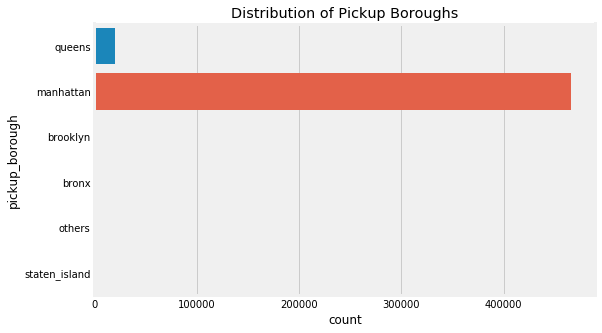

In [48]:
train=pd.read_csv("Training_FeatureEngineering.csv")
plt.figure(figsize=(8,5))
sns.countplot(y=train['pickup_borough'])
plt.title("Distribution of Pickup Boroughs")

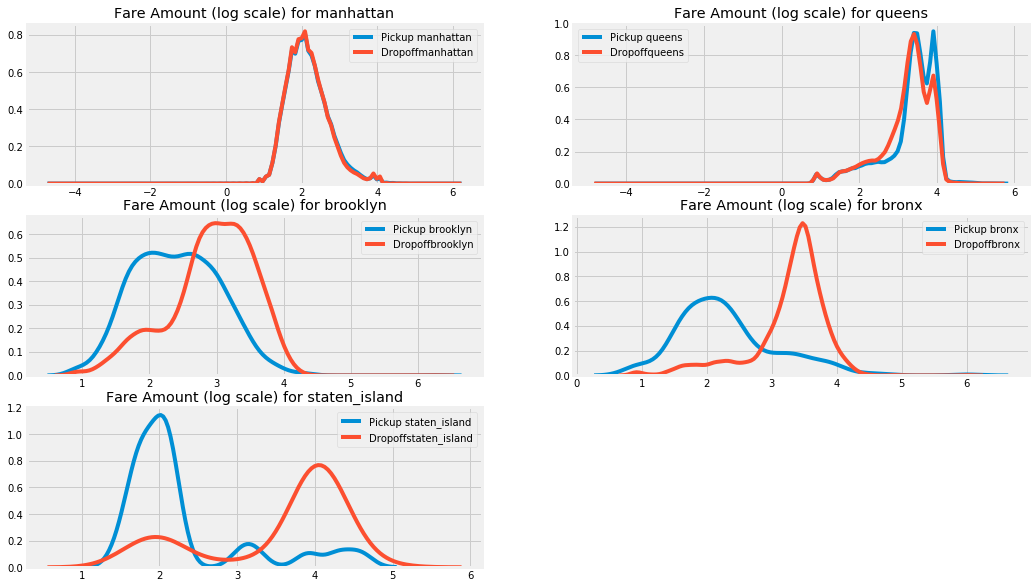

In [49]:


plt.figure(figsize=(16,10))
plt.title("Distribution of Fare Amount Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'fare_amount'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'fare_amount'].values),label='Dropoff'+ key).set_title("Fare Amount (log scale) for "+key)
    
    i=i+1


There is a significant difference in pickups and dropoffs fare amount for each burough exceept Manhattan. We can see pickups from Queens is expensive compared to pickups from other Buroughs.Very high difference in pickup and dropoff prices for Staten Island.

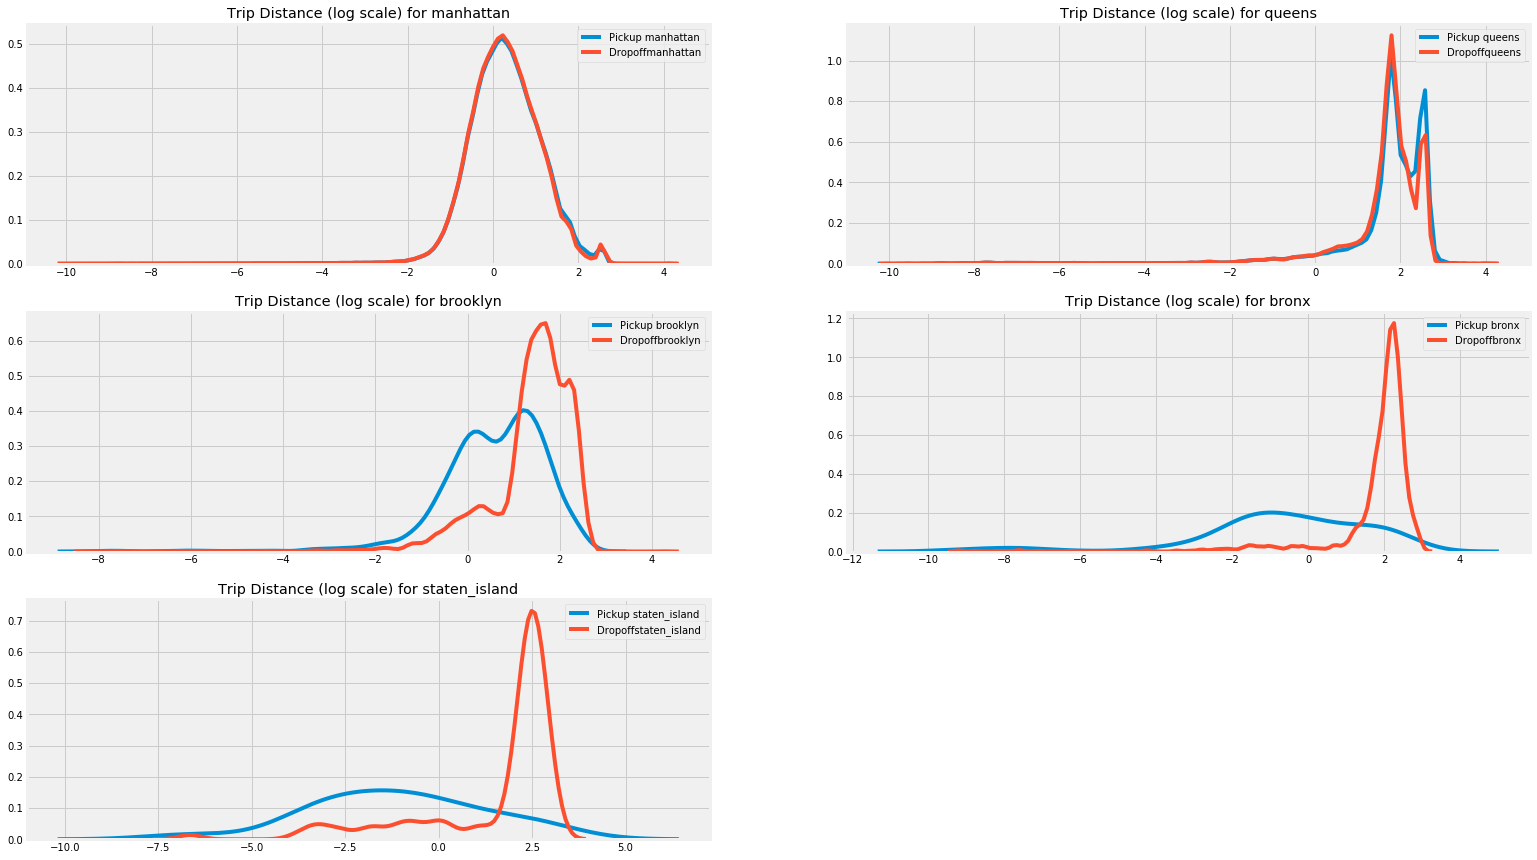

In [50]:
plt.figure(figsize=(24,15))
plt.title("Distribution of Trip Distances Across Buroughs")
i=1
for key in nyc_boroughs.keys():
    plt.subplot(3,2,i)
    sns.kdeplot(np.log(train.loc[train['pickup_borough']==key,'trip_distance'].values),label='Pickup '+ key)
    sns.kdeplot(np.log(train.loc[train['dropoff_borough']==key,'trip_distance'].values),label='Dropoff'+ key).set_title("Trip Distance (log scale) for "+key)
    i=i+1

Dropoffs to Bronx and Staten island are long trips. In Manhattan the pickup and dropoffs fare amount has similar distribution. Let us add a field, is_lower_manhattan as we had seen above that dropoffs to lower manhattan had higher trip distance but lower fare

In [51]:

lower_manhattan_boundary={'min_lng': -74.0194,
                          'min_lat':40.6997,
                          'max_lng':-73.9716,
                          'max_lat':40.7427}

def isLowerManhattan(lat,lng):
    if lat>=lower_manhattan_boundary['min_lat'] and lat<=lower_manhattan_boundary['max_lat'] and lng>=lower_manhattan_boundary['min_lng'] and lng<=lower_manhattan_boundary['max_lng']:
        return 1
    else:
        return 0
    

In [52]:
train['is_pickup_lower_manhattan']=train.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
train['is_dropoff_lower_manhattan']=train.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)

**How does Fare Amount differ for pickups and dropoff for Lower Manhattan compared to rest of Manhattan**

In [53]:
manhattan=train.loc[(train['pickup_borough']=='manhattan') | (train['dropoff_borough']=='manhattan')]
manhattan.shape

(481497, 31)

Text(0.5, 1.0, 'Distribution of Fare Amount - Manhattan vs Lower Manhattan')

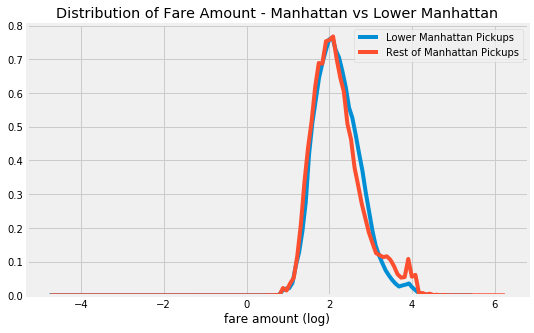

In [54]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'fare_amount'].values),label='Lower Manhattan Pickups')
sns.kdeplot(np.log(manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'fare_amount'].values),label='Rest of Manhattan Pickups')
plt.xlabel("fare amount (log)")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

Text(0.5, 1.0, 'Distribution of Fare Amount - Manhattan vs Lower Manhattan')

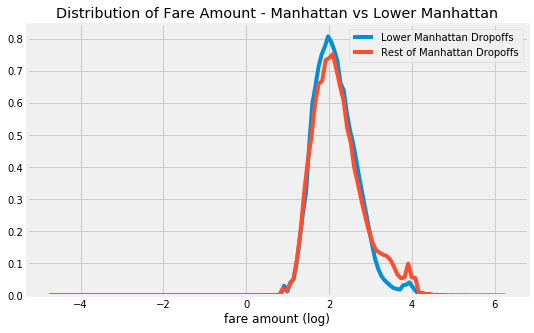

In [55]:
plt.figure(figsize=(8,5))
sns.kdeplot(np.log(manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'fare_amount'].values),label='Lower Manhattan Dropoffs')
sns.kdeplot(np.log(manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'fare_amount'].values),label='Rest of Manhattan Dropoffs')
plt.xlabel("fare amount (log)")
plt.title("Distribution of Fare Amount - Manhattan vs Lower Manhattan")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Lower Manhattan pickups)')

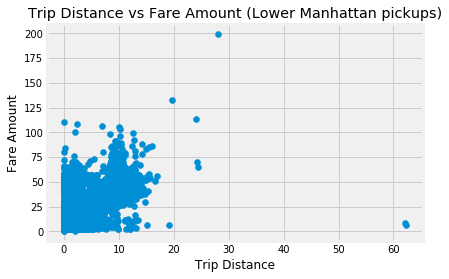

In [56]:
plt.scatter(x=manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'trip_distance'].values,y=manhattan.loc[manhattan['is_pickup_lower_manhattan']==1,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan pickups)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Rest of Manhattan pickups)')

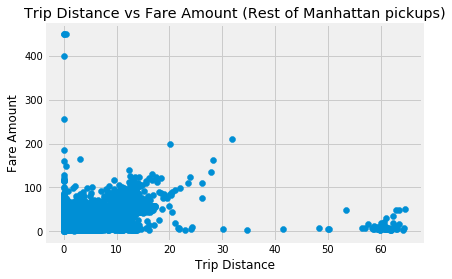

In [57]:
plt.scatter(x=manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'trip_distance'].values,y=manhattan.loc[manhattan['is_pickup_lower_manhattan']==0,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan pickups)")

Text(0.5, 1.0, 'Trip Distance vs Fare Amount (Lower Manhattan dropoffs)')

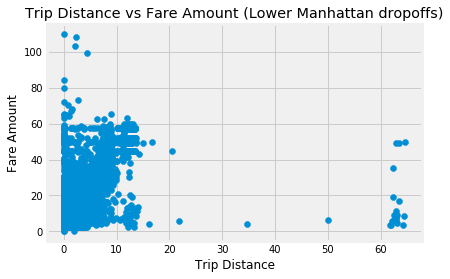

In [58]:
plt.scatter(x=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'trip_distance'].values,y=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==1,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Lower Manhattan dropoffs)")

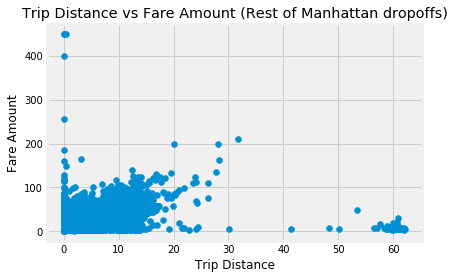

In [59]:
plt.scatter(x=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'trip_distance'].values,y=manhattan.loc[manhattan['is_dropoff_lower_manhattan']==0,'fare_amount'].values)
plt.xlabel("Trip Distance")
plt.ylabel("Fare Amount")
plt.title("Trip Distance vs Fare Amount (Rest of Manhattan dropoffs)")

del manhattan
del non_airport_long_trips
del non_airport

The distribution of trip distance and fare amount for Lower Manhattan pickups and dropoffs is very different. Also, slope of linear realtionship for pickups for Lower Manhattan is higher than that for Rest of Manhattan

### Let us now look at datetime features and their realtionship with Fare Amount
**What is the time period  in out sample**

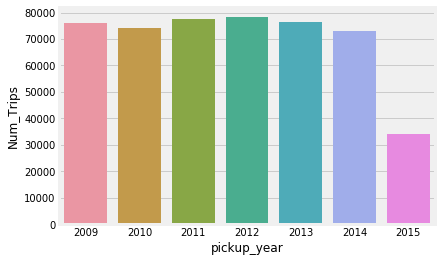

In [60]:
trips_year=train.groupby(['pickup_year'])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
trips_year.head()
sns.barplot(x='pickup_year',y='Num_Trips',data=trips_year)

In [61]:
trips_year_fareamount=train.groupby(['pickup_year'])['fare_amount'].mean().reset_index().rename(columns={'fare_amount':'avg_fare_amount'})

Text(0.5, 1.0, 'Avg Fare Amount over Years')

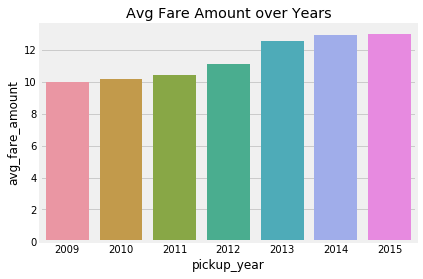

In [62]:
sns.barplot(x='pickup_year',y='avg_fare_amount',data=trips_year_fareamount).set_title("Avg Fare Amount over Years")

Avg Fare amount has beern increasing over the years.

In [63]:
def groupandplot(data,groupby_key,value,aggregate='mean'):
    plt.figure(figsize=(16,10))
    agg_data=data.groupby([groupby_key])[value].agg(aggregate).reset_index().rename(columns={value:aggregate+'_'+value})
    plt.subplot(1,2,1)
    count_data=train.groupby([groupby_key])['key'].count().reset_index().rename(columns={'key':'Num_Trips'})
    sns.barplot(x=groupby_key,y='Num_Trips',data=count_data).set_title("Number of Trips vs "+groupby_key)
    
    plt.subplot(1,2,2)
    sns.barplot(x=groupby_key,y=aggregate+'_'+value,data=agg_data).set_title(aggregate+'_'+value+" vs "+groupby_key)

    

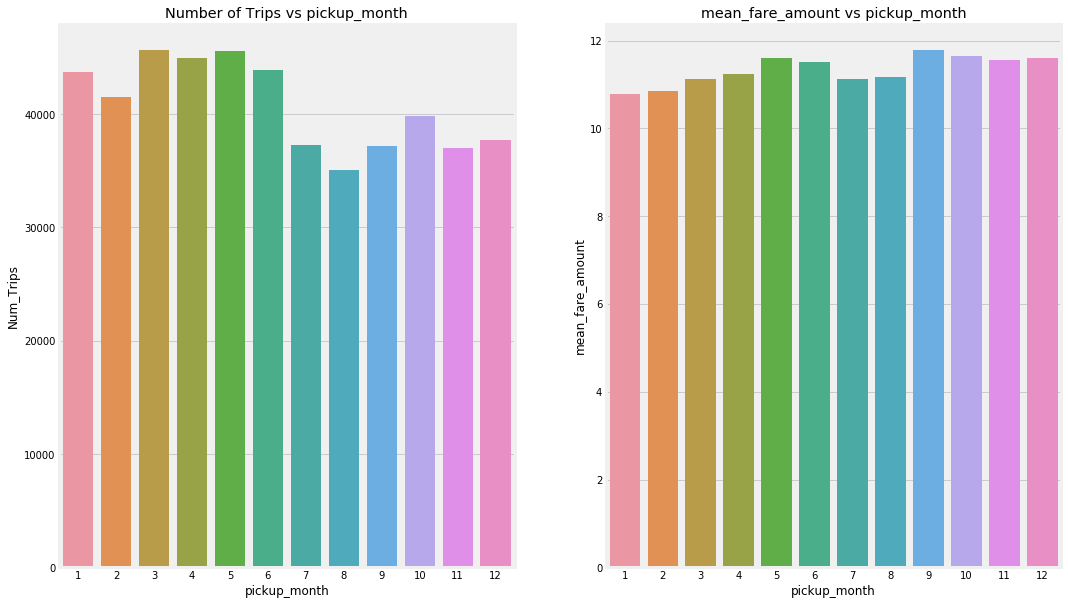

In [64]:
groupandplot(train,'pickup_month','fare_amount')

Fares across months are fairly constant, though number of trips are lower from june to decemeber

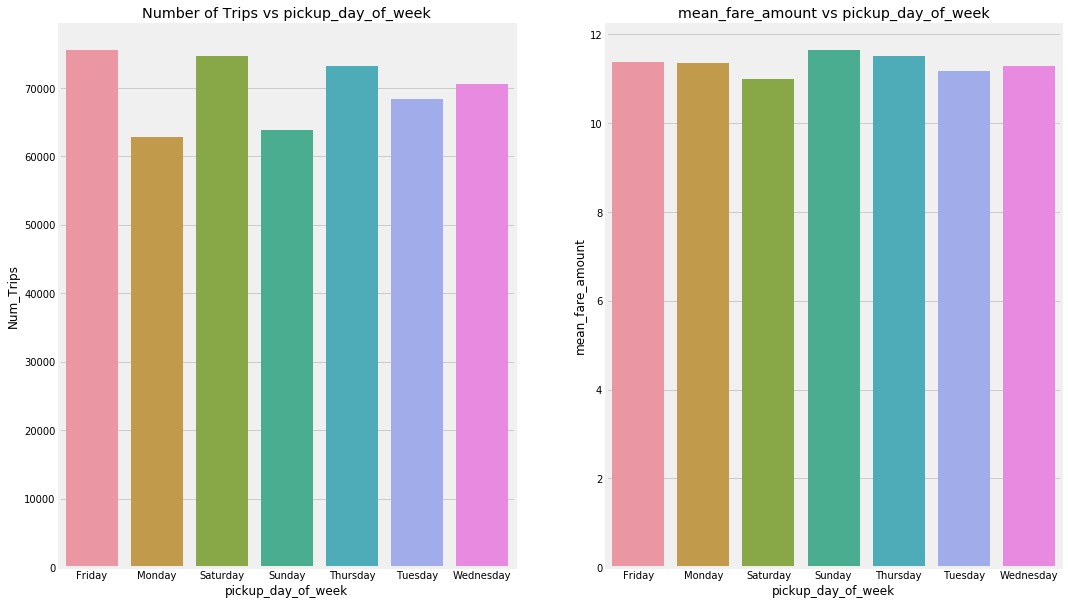

In [65]:
groupandplot(train,'pickup_day_of_week','fare_amount')

Saturday has low avg fare amount, compared to other days though there are a lot of trips of saturday. On sunday and monday though the number of trips are lower, avg fare amount is higher

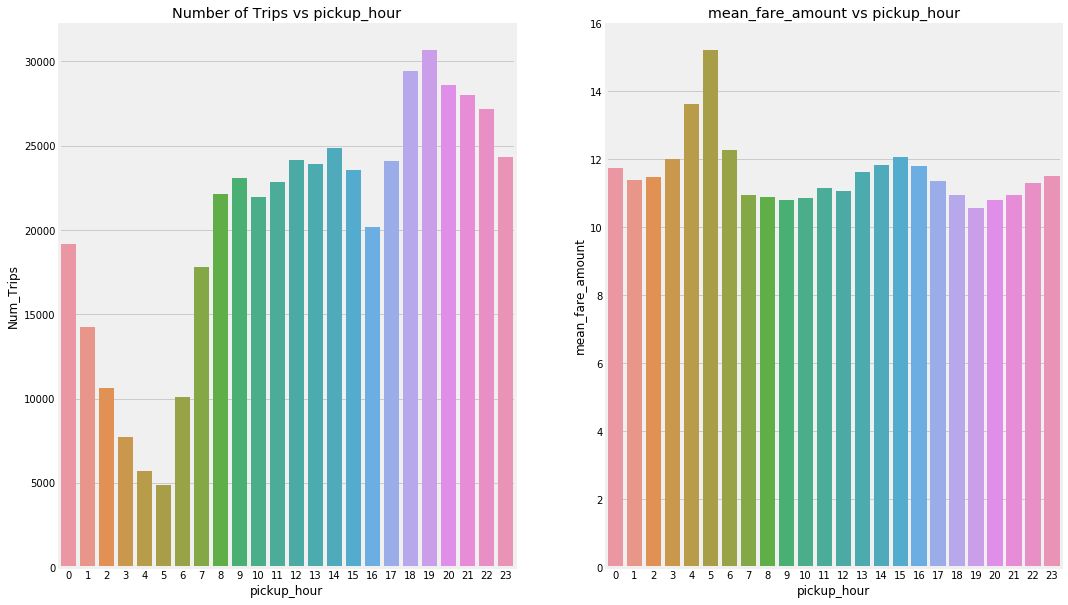

In [66]:
groupandplot(train,'pickup_hour','fare_amount')

The avg fare amount at 5am is the higher while the number of trips at 5 am are the least. The number of trips are highest in 18 and 19 hours

In [67]:
# Let us encode day of the week to numbers
def encodeDays(day_of_week):
    day_dict={'Sunday':0,'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5,'Saturday':6}
    return day_dict[day_of_week]

In [68]:
train['pickup_day_of_week']=train['pickup_day_of_week'].apply(lambda x:encodeDays(x))

### How does Number of passengers affect Fare time


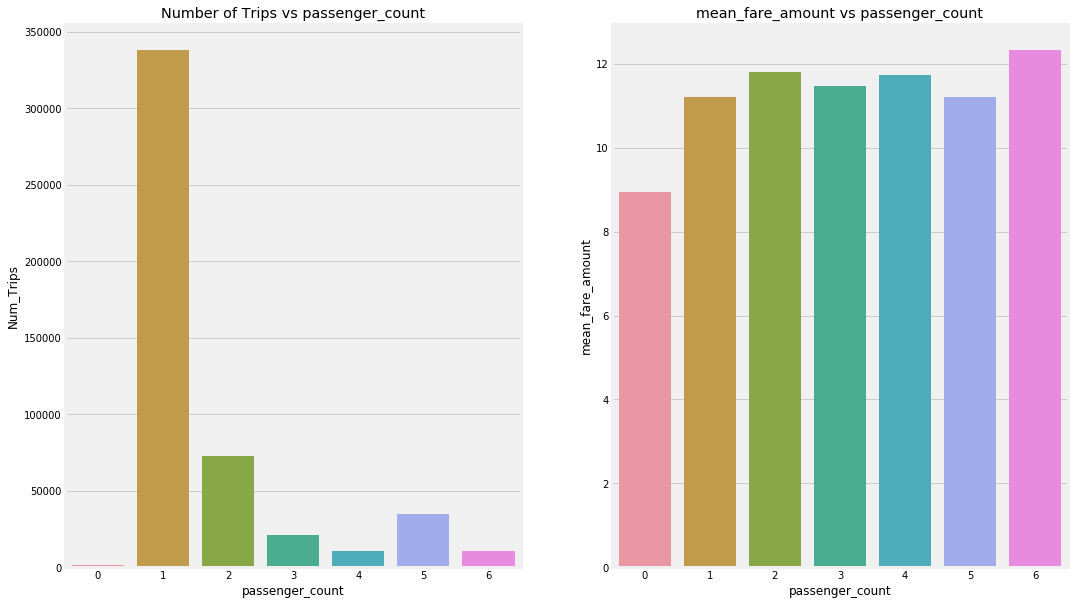

In [69]:

groupandplot(train,'passenger_count','fare_amount')

1. There are trips with 0 passengers as well. In these cases are drop and pickup location the same? If so it would mean that passenger didnt take the cab after the cab arrived and a cancellation fee was charged - there were 20719 such records. In the test set there were 38 such records
2. The fare is very high when there were 9 passengers. - only 2 records
3.  the number 129 and 208 passengers are surely outliers - three such records
4. There are no records in test data where number of passengers is greater than 8 - so we will remove from train data records where number of passengers >8

In [70]:
print("Avg trip distance (in miles) when there are zero passengers",np.mean(train.loc[train['passenger_count']==0,'trip_distance'].values))

Avg trip distance (in miles) when there are zero passengers 1.7673143933618185


In [71]:
train=train[train['passenger_count']<=8]

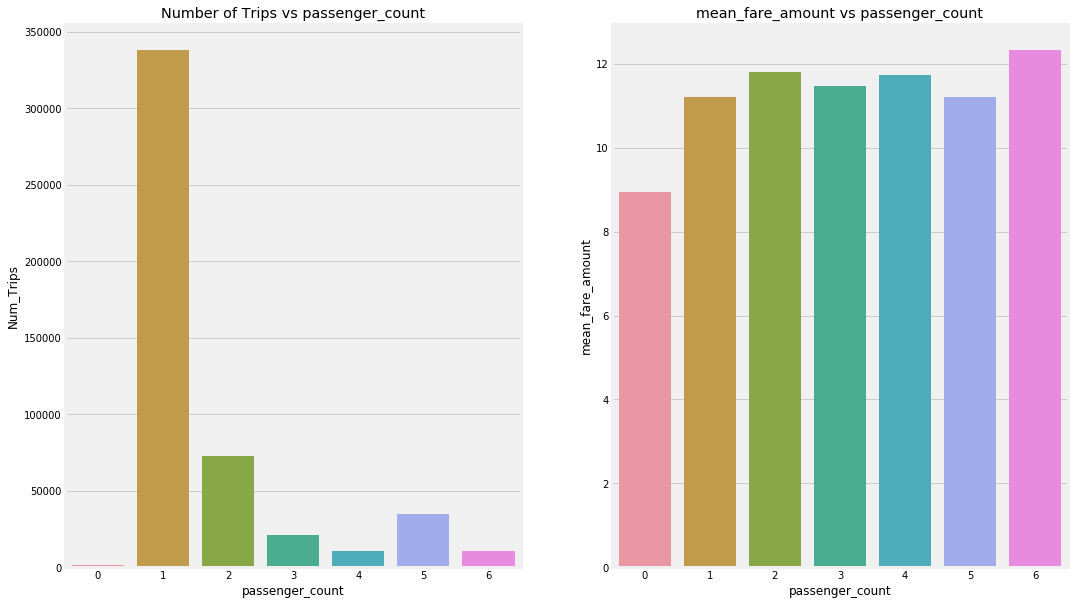

In [72]:
groupandplot(train,'passenger_count','fare_amount')


 if there are 7 passengers, fare amount is lower. Fare amount is higher for 6 passengers**

In [73]:
train.to_csv("train_cleaned.csv",index=False)

In [74]:


test =  pd.read_csv('../DATA/NY_taxi_test.csv')
test['pickup_datetime']=pd.to_datetime(test['pickup_datetime'],format='%Y-%m-%d %H:%M:%S UTC')

test['pickup_date']= test['pickup_datetime'].dt.date
test['pickup_day']=test['pickup_datetime'].apply(lambda x:x.day)
test['pickup_hour']=test['pickup_datetime'].apply(lambda x:x.hour)
test['pickup_day_of_week']=test['pickup_datetime'].apply(lambda x:calendar.day_name[x.weekday()])
test['pickup_month']=test['pickup_datetime'].apply(lambda x:x.month)
test['pickup_year']=test['pickup_datetime'].apply(lambda x:x.year)
test['is_pickup_JFK']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'JFK'),axis=1)
test['is_dropoff_JFK']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'JFK'),axis=1)
test['is_pickup_EWR']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'EWR'),axis=1)
test['is_dropoff_EWR']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'EWR'),axis=1)
test['is_pickup_la_guardia']=test.apply(lambda row:isAirport(row['pickup_latitude'],row['pickup_longitude'],'LaGuardia'),axis=1)
test['is_dropoff_la_guardia']=test.apply(lambda row:isAirport(row['dropoff_latitude'],row['dropoff_longitude'],'LaGuardia'),axis=1)
test['pickup_latitude_round3']=test['pickup_latitude'].apply(lambda x:round(x,3))
test['pickup_longitude_round3']=test['pickup_longitude'].apply(lambda x:round(x,3))
test['dropoff_latitude_round3']=test['dropoff_latitude'].apply(lambda x:round(x,3))
test['dropoff_longitude_round3']=test['dropoff_longitude'].apply(lambda x:round(x,3))
test['trip_distance']=test.apply(lambda row:distance(row['pickup_latitude'],row['dropoff_latitude'],row['pickup_longitude'],row['dropoff_longitude']),axis=1)
test['pickup_borough']=test.apply(lambda row:getBorough(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['dropoff_borough']=test.apply(lambda row:getBorough(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
test['is_pickup_lower_manhattan']=test.apply(lambda row:isLowerManhattan(row['pickup_latitude'],row['pickup_longitude']),axis=1)
test['is_dropoff_lower_manhattan']=test.apply(lambda row:isLowerManhattan(row['dropoff_latitude'],row['dropoff_longitude']),axis=1)
test['pickup_day_of_week']=test['pickup_day_of_week'].apply(lambda x:encodeDays(x))
print("Shape of test data", test.shape)

test.to_csv("test_cleaned.csv",index=False)

Shape of test data (9914, 28)


## Build ML Model

In [75]:
train=pd.read_csv('train_cleaned.csv')
test=pd.read_csv('test_cleaned.csv')
print("Shape of Training Data ",train.shape)
print("Shape of Testing Data ",test.shape)

Shape of Training Data  (489356, 31)
Shape of Testing Data  (9914, 28)


### Pre-Processing data

1. Remove the unwanted columns like pickup_datetime, key, pickup_date, latitude and longitude rounded to 3 decimal places
2. One hot encoding of categorical variables
3. Divide training data into train and validation datasets - 80% training and 20% validation

In [76]:
drop_columns=['key','pickup_datetime','pickup_date','pickup_latitude_round3','pickup_longitude_round3','dropoff_latitude_round3','dropoff_longitude_round3']

In [77]:
train_1=train.drop(drop_columns,axis=1)
test_1=test.drop(drop_columns,axis=1)
print("Shape of Training Data after dropping columns",train_1.shape)
print("Shape of Testing Data after dropping columns",test_1.shape)

Shape of Training Data after dropping columns (489356, 24)
Shape of Testing Data after dropping columns (9914, 21)


In [78]:
train_1=pd.get_dummies(train_1)
test_1=pd.get_dummies(test_1)

print("Shape of Training Data after One Hot Encoding",train_1.shape)
print("Shape of Testing Data after One Hot Encoding",test_1.shape)

Shape of Training Data after One Hot Encoding (489356, 34)
Shape of Testing Data after One Hot Encoding (9914, 31)


In [79]:
X=train_1.drop(['fare_amount'],axis=1)
y=train_1['fare_amount']


In [80]:
#split data into train and validation data
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)
print("Number of records in training data ",X_train.shape[0])
print("Number of records in validation data ",X_test.shape[0])

Number of records in training data  391484
Number of records in validation data  97872


### ML Model Building
#### Very Simple Linear Regression

In [81]:
lm = LinearRegression()
lm.fit(X_train,y_train)
y_pred=lm.predict(X_test)
lm_rmse=np.sqrt(mean_squared_error(y_pred, y_test))
print("RMSE for Linear Regression is ",lm_rmse)

RMSE for Linear Regression is  4.67289376184816
